# Fig 6a

In [1]:
import os
import fnmatch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from statannotations.Annotator import Annotator
from Bio import SeqIO, Seq, SeqRecord

## Prepare reference genome

In [13]:
%%bash
# detect plasmids in genomes
cd /home/shenz4/data/software/PLASMe/
# genome_path="/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/"
# genome_path="/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/"
# genome_path="/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/"
# genome_path="/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
# genome_path="/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
genome_path="/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
for in_file in $(ls ${genome_path}/*.fna); do
    out_file=$(echo $in_file | sed s/dereplicated_genomes/dereplicated_genomes_plasmid_removed/g | sed s/.fna/.plasmid.fna/g)
    # if [ -f ${out_file} ]; then
    #     continue
    # fi
    bash_script=/lscratch/${SLURM_JOB_ID}/plasme.sh
    echo $in_file
    truncate -s 0 ${bash_script}
    echo '#!/bin/sh' >> $bash_script
    echo "set -e" >> $bash_script
    echo "source /data/$USER/conda/etc/profile.d/conda.sh" >> $bash_script
    echo "conda activate plasme" >> $bash_script
    echo "python PLASMe.py ${in_file} ${out_file} --thread \$SLURM_CPUS_PER_TASK --temp ${in_file}_temp" >> $bash_script
    # cat $bash_script
    sbatch --cpus-per-task=16 --time=2:00:00 $bash_script
    # break
done

/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_001622205.1_ASM162220v1_genomic.fna
63776695
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_001622305.1_ASM162230v1_genomic.fna
63776699
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_002078765.3_ASM207876v3_genomic.fna
63776700
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_002078935.2_ASM207893v2_genomic.fna
63776701
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_002441765.1_ASM244176v1_genomic.fna
63776702
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes//GCA_003346395.1_ASM334639v1_g

In [13]:
# Remove plasmids from reference genomes
paths = ["/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/", 
         "/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/", 
         "/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/", 
         "/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/", 
         "/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/", 
         "/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/"]
for genome_path in paths:
    plasmid_folder = genome_path.replace('dereplicated_genomes/', 'dereplicated_genomes_plasmid_removed/')
    genome_files = sorted(fnmatch.filter(os.listdir(genome_path), '*.fasta'))+sorted(fnmatch.filter(os.listdir(genome_path), '*.fna'))
    print(len(genome_files))
    for genome_file in genome_files:
        plasmid_file = plasmid_folder+genome_file.replace('.fna', '.plasmid.fna').replace('.fasta', '.plasmid.fna')
        plasmid_report = plasmid_file+'_report.csv'
        report_df = pd.read_csv(plasmid_report, sep='\t')
        plasmid_contigs = []
        for row in report_df.iterrows():
            length = row[1]['length']
            if str(row[1]['amb_region']) == 'nan':
                plasmid_contigs.append(row[1]['contig'])
            else:
                amb_regions = [r.split('-') for r in row[1]['amb_region'].split(',')]
                amb_region_len = sum([int(r[1])-int(r[0]) for r in amb_regions])
                amb_prop = amb_region_len/length
                if amb_prop < 0.4:
                    plasmid_contigs.append(row[1]['contig'])
        print(genome_file, len(plasmid_contigs))
        noplasmid_seqs = []
        for seq_record in SeqIO.parse(os.path.join(genome_path, genome_file), "fasta"):
            if seq_record.id not in plasmid_contigs:
                noplasmid_seqs.append(seq_record)
        output_filename = plasmid_file.replace('.plasmid.fna', '.noplasmid.fna')
        SeqIO.write(noplasmid_seqs, output_filename, "fasta")

173
ERR1753378.fasta 2
ERR1753391.fasta 3
ERR1753405.fasta 3
ERR1753408.fasta 56
ERR1753446.fasta 3
ERR1753450.fasta 3
ERR1753469.fasta 3
ERR1753485.fasta 2
ERR1753494.fasta 0
ERR1753495.fasta 1
ERR1903992.fasta 1
ERR1904172.fasta 1
ERR1904227.fasta 12
ERR1904229.fasta 15
ERR1904231.fasta 23
ERR1904233.fasta 19
ERR2094464.fasta 1
ERR2309540.fasta 2
ERR2309542.fasta 7
ERR2309568.fasta 1
ERR2309575.fasta 1
ERR2309580.fasta 5
ERR2309589.fasta 2
ERR2309594.fasta 6
ERR2309597.fasta 0
ERR2309603.fasta 1
ERR5083333.fasta 14
ERR5083339.fasta 75
ERR5083354.fasta 29
ERR5083359.fasta 7
ERR5083364.fasta 32
ERR5083373.fasta 26
ERR5083374.fasta 30
ERR9031938.fasta 3
FDAARGOS_161.fasta 1
GCA_0101361151.fasta 5
GCA_0101365451.fasta 7
GCA_0101371951.fasta 8
GCA_0101374551.fasta 4
GCA_0101377551.fasta 2
GCA_0101378951.fasta 8
GCA_0101389151.fasta 14
GCA_0101392551.fasta 14
GCA_0101399851.fasta 5
GCA_0101432151.fasta 19
GCA_0101435051.fasta 5
GCA_0101437151.fasta 26
GCA_0101441851.fasta 28
GCA_0101443751

In [58]:
%%bash
# sketch reference genomes
source /data/$USER/conda/etc/profile.d/conda.sh
conda activate strainge
declare -a arr=(
# "/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/" 
"/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/" 
# "/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/"
# "/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
# "/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
# "/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
)

kmer=23
for genome_path in "${arr[@]}"
do
   echo "$genome_path"
   cd ${genome_path}/../dereplicated_genomes_plasmid_removed/
   mkdir -p strainge
   truncate -s 0 cmds.txt
   for f in $(ls *.noplasmid.fna); do
       echo "straingst kmerize -k $kmer -o ./strainge/${f}.k${kmer}.hdf5 $f" >> cmds.txt
   done
   parallel --jobs $SLURM_CPUS_PER_TASK < cmds.txt
done

/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/


2025-08-01 16:56:22,273 - INFO:root:K-merizing file GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna...
2025-08-01 16:56:22,849 - INFO:root:Writing k-merset to ./strainge/GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23.hdf5
2025-08-01 16:56:22,298 - INFO:root:K-merizing file GCA_000363005.1_Stap_aure_M1216_V1_genomic.noplasmid.fna...
2025-08-01 16:56:22,919 - INFO:root:Writing k-merset to ./strainge/GCA_000363005.1_Stap_aure_M1216_V1_genomic.noplasmid.fna.k23.hdf5
2025-08-01 16:56:22,342 - INFO:root:K-merizing file GCA_008619595.1_ASM861959v1_genomic.noplasmid.fna...
2025-08-01 16:56:22,961 - INFO:root:Writing k-merset to ./strainge/GCA_008619595.1_ASM861959v1_genomic.noplasmid.fna.k23.hdf5
2025-08-01 16:56:22,362 - INFO:root:K-merizing file GCA_002224825.1_ASM222482v1_genomic.noplasmid.fna...
2025-08-01 16:56:22,966 - INFO:root:Writing k-merset to ./strainge/GCA_002224825.1_ASM222482v1_genomic.noplasmid.fna.k23.hdf5
2025-08-01 16:56:22,420 - INFO:root:K-merizing file GCA_00973159

In [26]:
%%bash
# create database
source /data/$USER/conda/etc/profile.d/conda.sh
conda activate strainge
declare -a arr=(
"/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/" 
"/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/" 
"/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
)

kmer=23
for genome_path in "${arr[@]}"
do
    echo "$genome_path"
    cd ${genome_path}/../dereplicated_genomes_plasmid_removed/
    sim_file="./strainge/similarities.k${kmer}.tsv"
    cluster_file=$(echo $sim_file | sed s/similarities/clusters/g)
    keep_file=$(echo $sim_file | sed s/similarities/references_to_keep/g | sed s/.tsv/.txt/g)
    db_file=$(echo $sim_file | sed s/similarities/pan-genome-db/g | sed s/.tsv/.hdf5/g)
    # straingst kmersim --all-vs-all -t $SLURM_CPUS_PER_TASK -S jaccard -S subset $(ls ./strainge/*.k${kmer}.hdf5 | grep -v pan-genome) > $sim_file
    # straingst cluster -i $sim_file -d -C 0.99 -c 0.95 --clusters-out $cluster_file $(ls ./strainge/*.k${kmer}.hdf5 | grep -v pan-genome) > $keep_file
    # straingst createdb -f $keep_file -o $db_file
    wc -l $keep_file
done

/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/


2025-08-02 11:14:01,308 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:14:01,309 - INFO:root:Loading k-mer sets...
2025-08-02 11:14:02,812 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatym.noplasmid.fna.k23...
2025-08-02 11:14:02,813 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzb.noplasmid.fna.k23...
2025-08-02 11:14:02,814 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzg.noplasmid.fna.k23...
2025-08-02 11:14:02,815 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzi.noplasmid.fna.k23...
2025-08-02 11:14:02,815 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzj.noplasmid.fna.k23...
2025-08-02 11:14:02,816 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzk.noplasmid.fna.k23...
2025-08-02 11:14:02,817 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzl.noplasmid.fna.k23...
2025-08-02 11:14:02,817 - INFO:root:Comparing aacok.noplasmid.fna.k23 vs aatzm.noplasmid.fna.k23...
2025-08-02 11:14:02,818 - INFO:root:Comparing aacok.noplasmid.fna

169 ./strainge/references_to_keep.k23.txt
/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/


2025-08-02 11:16:18,719 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:16:18,719 - INFO:root:Loading k-mer sets...
2025-08-02 11:16:19,396 - INFO:root:Comparing GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23 vs GCA_000189455.3_ASM18945v3_genomic.noplasmid.fna.k23...
2025-08-02 11:16:19,397 - INFO:root:Comparing GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23 vs GCA_000280745.1_S.aureus_GR1_1.0_genomic.noplasmid.fna.k23...
2025-08-02 11:16:19,398 - INFO:root:Comparing GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23 vs GCA_000361045.1_Stap_aure_M0396_V1_genomic.noplasmid.fna.k23...
2025-08-02 11:16:19,398 - INFO:root:Comparing GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23 vs GCA_000363005.1_Stap_aure_M1216_V1_genomic.noplasmid.fna.k23...
2025-08-02 11:16:19,399 - INFO:root:Comparing GCA_000162635.1_ASM16263v1_genomic.noplasmid.fna.k23 vs GCA_000735755.1_SK1585_newbler2.6_V1_genomic.noplasmid.fna.k23...
2025-08-02 11:16:19,400 - INFO:root:Compari

87 ./strainge/references_to_keep.k23.txt
/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/


2025-08-02 11:17:24,241 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:17:24,241 - INFO:root:Loading k-mer sets...
2025-08-02 11:17:24,414 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs Cacn_V00874C_aejkc.spades.pilon.noplasmid.fna.k23...
2025-08-02 11:17:24,415 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs Cacn_V00968C_aejkh.spades.pilon.noplasmid.fna.k23...
2025-08-02 11:17:24,415 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs Cacn_V01087C_aejkk.spades.pilon.noplasmid.fna.k23...
2025-08-02 11:17:24,416 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs Cacn_V01111C_aejkm.spades.pilon.noplasmid.fna.k23...
2025-08-02 11:17:24,416 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs Cacn_V02407C_aejku.spades.pilon.noplasmid.fna.k23...
2025-08-02 11:17:24,416 - INFO:root:Comparing Cacn_V00199C_aejjf.spades.pilon.noplasmid.fna.k23 vs GCA_00

12 ./strainge/references_to_keep.k23.txt
/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/


2025-08-02 11:17:36,424 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:17:36,424 - INFO:root:Loading k-mer sets...
2025-08-02 11:17:36,615 - INFO:root:Comparing GCA_000725405.1_ASM72540v1_genomic.noplasmid.fna.k23 vs GCA_001908935.1_ASM190893v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:36,616 - INFO:root:Comparing GCA_000725405.1_ASM72540v1_genomic.noplasmid.fna.k23 vs GCA_001908945.1_ASM190894v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:36,617 - INFO:root:Comparing GCA_000725405.1_ASM72540v1_genomic.noplasmid.fna.k23 vs GCA_005048255.1_ASM504825v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:36,617 - INFO:root:Comparing GCA_000725405.1_ASM72540v1_genomic.noplasmid.fna.k23 vs GCA_007673145.1_ASM767314v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:36,618 - INFO:root:Comparing GCA_000725405.1_ASM72540v1_genomic.noplasmid.fna.k23 vs GCA_007677465.1_ASM767746v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:36,619 - INFO:root:Comparing GCA_000725405.1_ASM72540

15 ./strainge/references_to_keep.k23.txt
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/


2025-08-02 11:17:52,258 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:17:52,258 - INFO:root:Loading k-mer sets...
2025-08-02 11:17:52,900 - INFO:root:Comparing GCA_000761115.1_ASM76111v1_genomic.noplasmid.fna.k23 vs GCA_002408325.1_ASM240832v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:52,900 - INFO:root:Comparing GCA_000761115.1_ASM76111v1_genomic.noplasmid.fna.k23 vs GCA_002416215.1_ASM241621v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:52,901 - INFO:root:Comparing GCA_000761115.1_ASM76111v1_genomic.noplasmid.fna.k23 vs GCA_002428135.1_ASM242813v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:52,901 - INFO:root:Comparing GCA_000761115.1_ASM76111v1_genomic.noplasmid.fna.k23 vs GCA_002454435.1_ASM245443v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:52,902 - INFO:root:Comparing GCA_000761115.1_ASM76111v1_genomic.noplasmid.fna.k23 vs GCA_002477395.1_ASM247739v1_genomic.noplasmid.fna.k23...
2025-08-02 11:17:52,902 - INFO:root:Comparing GCA_000761115.1_ASM76111

74 ./strainge/references_to_keep.k23.txt
/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/


2025-08-02 11:18:43,272 - INFO:root:Start computing pairwise similarities...
2025-08-02 11:18:43,272 - INFO:root:Loading k-mer sets...
2025-08-02 11:18:43,609 - INFO:root:Comparing GCA_001622205.1_ASM162220v1_genomic.noplasmid.fna.k23 vs GCA_001622305.1_ASM162230v1_genomic.noplasmid.fna.k23...
2025-08-02 11:18:43,610 - INFO:root:Comparing GCA_001622205.1_ASM162220v1_genomic.noplasmid.fna.k23 vs GCA_002078765.3_ASM207876v3_genomic.noplasmid.fna.k23...
2025-08-02 11:18:43,611 - INFO:root:Comparing GCA_001622205.1_ASM162220v1_genomic.noplasmid.fna.k23 vs GCA_002078935.2_ASM207893v2_genomic.noplasmid.fna.k23...
2025-08-02 11:18:43,611 - INFO:root:Comparing GCA_001622205.1_ASM162220v1_genomic.noplasmid.fna.k23 vs GCA_002441765.1_ASM244176v1_genomic.noplasmid.fna.k23...
2025-08-02 11:18:43,612 - INFO:root:Comparing GCA_001622205.1_ASM162220v1_genomic.noplasmid.fna.k23 vs GCA_003346395.1_ASM334639v1_genomic.noplasmid.fna.k23...
2025-08-02 11:18:43,612 - INFO:root:Comparing GCA_001622205.1_ASM

31 ./strainge/references_to_keep.k23.txt


## Predict strains for metagenomes

In [27]:
%%bash
# sketch metagenomes
kmer=23
for dir in $(ls -d /data/shenz4/Vitality/data/MAG/V* | grep -v -e _St_ -e _N_) $(ls -d /data/shenz4/Vitality/data/MAG/ns*/V* | grep -v -e _St_ -e _N_); do
    group=$(echo $dir | rev | cut -d "/" -f1 | rev)
    if [ -f ${dir}/${group}_strainge.k${kmer}.hdf5 ]; then
        continue
    fi
    bash_script=/lscratch/${SLURM_JOB_ID}/straingst.sh
    echo $dir
    truncate -s 0 ${bash_script}
    echo '#!/bin/sh' >> $bash_script
    echo "set -e" >> $bash_script
    echo "source /data/$USER/conda/etc/profile.d/conda.sh" >> $bash_script
    echo "conda activate strainge" >> $bash_script
    echo "straingst kmerize -k ${kmer} -o ${dir}/${group}_strainge.k${kmer}.hdf5 ${dir}/raw/*.fastq.gz" >> $bash_script
    sbatch --cpus-per-task=8 --mem=200g --time=8:00:00 $bash_script
done

In [2]:
%%bash
# Run serotyping
declare -a arr=(
"/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_epidermidis/Sara_paper/drep_out_keepQuality/dereplicated_genomes/" 
"/home/shenz4/data/databases/genomes/bacteria/Staphylococcus_aureus/Sara_paper/dereplicated_genomes/" 
"/home/shenz4/data/databases/genomes/bacteria/Cutibacterium_acnes/drep_out/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Dermacoccus_nishinomiyaensis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Lactococcus_lactis/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
"/home/shenz4/data/databases/genomes/bacteria/Lactococcus_cremoris/all_genomes/drep_out_keepQuality/dereplicated_genomes/"
)
# pangenome_db="/home/shenz4/data/databases/genomes/bacteria/Streptococcus_thermophilus/complete_genomes/drep_out_keepQuality/dereplicated_genomes/strainge/pan-genome-db.hdf5"
kmer=23
for kmer_file in $(ls -d /home/shenz4/data/Vitality/data/MAG/V*/*_strainge.k${kmer}.hdf5 | grep -v -e _St_ -e _N_) $(ls -d /data/shenz4/Vitality/data/MAG/ns*/V*/*_strainge.k${kmer}.hdf5 | grep -v -e _St_ -e _N_); do
    bash_script=/lscratch/${SLURM_JOB_ID}/straingst.sh
    truncate -s 0 ${bash_script}
    echo '#!/bin/sh' >> $bash_script
    echo "set -e" >> $bash_script
    echo "source /data/$USER/conda/etc/profile.d/conda.sh" >> $bash_script
    echo "conda activate strainge" >> $bash_script
    count=0
    for genome_path in "${arr[@]}"; do
        pangenome_db="${genome_path}/../dereplicated_genomes_plasmid_removed/strainge/pan-genome-db.k${kmer}.hdf5"
        species=$(echo $genome_path | cut -d '/' -f8)
        output=$(echo $kmer_file | sed s/.k${kmer}.hdf5/.${species}.k${kmer}.tsv/g)
        # if [ -f ${output} ]; then
        #     continue
        # fi
        echo $output
        echo "straingst run -i 10 -o $output $pangenome_db $kmer_file" >> $bash_script
        ((count++))
    done
    if (( count > 0 )); then
        # echo $kmer_file
        # cat $bash_script
        sbatch --cpus-per-task=4 --mem=200g --time=2:00:00 $bash_script
        # bash $bash_script
        # break
    fi
done

/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Staphylococcus_epidermidis.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Staphylococcus_aureus.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Cutibacterium_acnes.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Dermacoccus_nishinomiyaensis.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Lactococcus_lactis.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac+Ch/V1008B_Ac+Ch_strainge.Lactococcus_cremoris.k23.tsv
64277495
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac/V1008B_Ac_strainge.Staphylococcus_epidermidis.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac/V1008B_Ac_strainge.Staphylococcus_aureus.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac/V1008B_Ac_strainge.Cutibacterium_acnes.k23.tsv
/home/shenz4/data/Vitality/data/MAG/V1008B_Ac/V1008B_Ac_strainge.Dermacoccus_nishinomiyaens

In [5]:
# Load metadata
patient_info = pd.read_excel("/home/shenz4/data/Vitality/ITN_clinic_dataset_21_08_2025.xlsx")
patient_info.index = ['V'+str(i) for i in patient_info['participant_id']]
group_dct = {'Non-allergic, Non-sensitised, No Eczema':'4', 'Non-allergic, Non-sensitised, Eczema':'3', 
             'Non-allergic, Sensitised':'2', 'Allergic':'1'}
patient_info['group'] = [group_dct[i] if i in group_dct else i for i in patient_info['itn_group_v3']]
patient_info['group2'] = patient_info['group']+'_'+patient_info['any_eczema_ever_d']
Counter(patient_info['group2'])

Counter({'3_yes': 473,
         '4_no': 625,
         '1_yes': 144,
         '2_yes': 58,
         '1_no': 35,
         '2_no': 39,
         '._yes': 2,
         '._no': 2})

In [6]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if '_St_' not in p and '_N_' not in p]
strain_counts_df = pd.DataFrame()
for target in ['Cutibacterium_acnes', 'Dermacoccus_nishinomiyaensis', 'Lactococcus_cremoris', 
               'Lactococcus_lactis', 'Staphylococcus_aureus', 'Staphylococcus_epidermidis']:
    print('Processing:', target)
    straingst_df = pd.DataFrame()
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Count strains
    matrix = straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
    cur_count = pd.DataFrame(matrix.notnull().sum(axis=1), columns=['count'])
    cur_count['babymom'] = [i.split('_')[0][-1] for i in cur_count.index]
    cur_count['babymom_site'] = [i.split('_')[0][-1]+'_'+i.split('_')[1] for i in cur_count.index]
    cur_count['target'] = target.split('_')[0][0]+'. '+'_'.join(target.split('_')[1:])#target_dct[target.split('_')[0]]
    cur_count['family_id'] = [i.split('_')[0][:-1] for i in cur_count.index]
    cur_count['group'] = [patient_info.loc[i, 'group'] for i in cur_count['family_id']]
    cur_count['group2'] = [patient_info.loc[i, 'group2'] for i in cur_count['family_id']]
    strain_counts_df = pd.concat([strain_counts_df, cur_count], axis=0)
strain_counts_df = strain_counts_df.reset_index()

Processing: Cutibacterium_acnes
Skipping: V1035B_Ac
Skipping: V1152B_Ac+Ch_T3
Skipping: V1159B_Ac+Ch
Skipping: V1230B_Ac_T3
Skipping: V1237B_Ac+Ch_T3
Skipping: V1259B_Ac+Ch
Skipping: V1260B_Ac
Skipping: V1314B_Ac+Ch
Skipping: V1315B_Ac+Ch
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1462B_Ac+Ch
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1473B_Ac+Ch_T1
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1622B_Ac+Ch
Skipping: V1628B_Ac+Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1664B_Ac+Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch
Processing: Dermacoccus_nishinomiyaensis
Skipping: V1035B_Ac
Skipping: V1152B_Ac+Ch_T3
Skipping: V1159B_Ac+Ch
Skipping: V1230B_Ac_T3
Skipping: V1237B_Ac+Ch_T3
Skipping: V1259B_Ac+Ch
Skipping: V1260B_Ac
Skipping: V1314B_Ac+Ch


In [7]:
strain_counts_df.groupby(['target', 'babymom']).median()

count
target              babymom       
C. acnes            B          7.0
                    M          8.0
D. nishinomiyaensis B          2.0
                    M          3.0
L. cremoris         B          1.0
                    M          2.0
L. lactis           B          1.0
                    M          1.0
S. aureus           B          1.0
                    M          1.0
S. epidermidis      B          3.0
                    M          4.0

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D. nishinomiyaensis_B vs. D. nishinomiyaensis_M: Mann-Whitney-Wilcoxon test two-sided, P_val:6.356e-02 U_stat=6.760e+03
C. acnes_B vs. C. acnes_M: Mann-Whitney-Wilcoxon test two-sided, P_val:1.736e-05 U_stat=1.772e+04
L. cremoris_B vs. L. cremoris_M: Mann-Whitney-Wilcoxon test two-sided, P_val:8.531e-01 U_stat=4.780e+03
L. lactis_B vs. L. lactis_M: Mann-Whitney-Wilcoxon test two-sided, P_val:3.254e-01 U_stat=4.239e+03
S. aureus_B vs. S. aureus_M: Mann-Whitney-Wilcoxon test two-sided, P_val:3.354e-01 U_stat=1.672e+03
S. epidermidis_B vs. S. epidermidis_M: Mann-Whitney-Wilcoxon test two-sided, P_val:8.496e-07 U_stat=1.508e+04


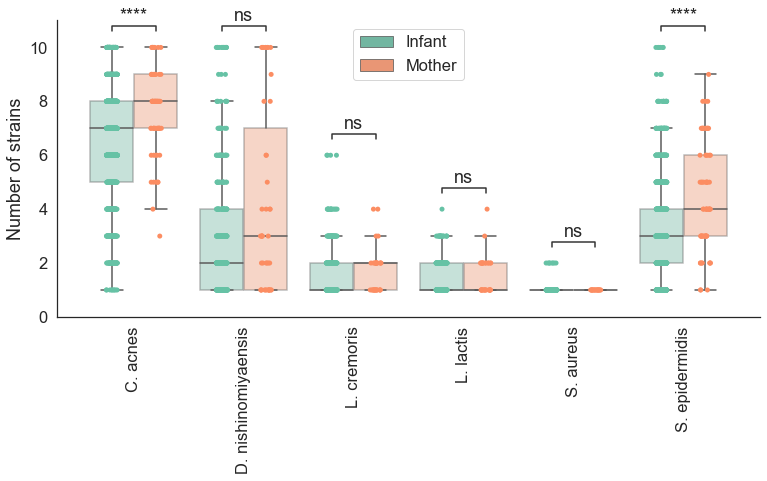

In [187]:
sns.set(style='white', font_scale=1.5)
sns.set_palette('Set2')
plt.figure(figsize=(11,7))
ax = sns.boxplot(data=strain_counts_df, x='target', y='count', hue='babymom', boxprops={'alpha': 0.4}, showfliers=False)
sns.stripplot(data=strain_counts_df, x='target', y='count', hue='babymom', dodge=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pairs = [[(t, i) for i in ['B', 'M']] for t in np.unique(strain_counts_df['target'])]
annotator = Annotator(ax, pairs, data=strain_counts_df, x='target', y='count', hue='babymom')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside').apply_and_annotate()
sns.despine(top=True)
plt.xlabel('')
plt.ylabel('Number of strains')
plt.legend(labels=['Infant', 'Mother'], title='', handles=ax.legend_.legendHandles)
sns.move_legend(ax, "upper center", frameon=True)
plt.ylim(0,strain_counts_df['count'].max()+1)
plt.tight_layout()
# plt.savefig('../figs/AD_strain_number.png', format='png', dpi=300)

# Fig 6b

In [13]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if 'St' not in p and 'N' not in p and '+' not in p]
all_overlap_df = pd.DataFrame()
shuffled_means_dct = {}
for target in ['Cutibacterium_acnes', 'Dermacoccus_nishinomiyaensis', 'Lactococcus_cremoris', 
               'Lactococcus_lactis', 'Staphylococcus_aureus', 'Staphylococcus_epidermidis']:
    print('Proceesing:', target)
    straingst_df = pd.DataFrame()
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Select baby-mom pairs
    matrix = straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
    family_dct = {}
    for r in matrix.index:
        fam = r.split('B')[0].split('M')[0]
        babymom = r.split(fam)[1].split('_')[0]
        if fam in family_dct:
            family_dct[fam] = family_dct[fam].union(set([babymom]))
        else:
            family_dct[fam] = set([babymom])
    select_fam = [fam for fam in family_dct if 'B' in family_dct[fam] and 'M' in family_dct[fam]]
    select_runs = [i for i in matrix.index if i.split('B')[0].split('M')[0] in select_fam and 'B+M' not in i]
    select_matrix = matrix.loc[select_runs]
    select_matrix = select_matrix.T.loc[select_matrix.notnull().sum(axis=0) > 0].T
    select_matrix = select_matrix.sort_index()

    # Store strains
    ST_dct = {}
    for row in select_matrix.iterrows():
        fam = row[0].split('_')[0][:-1]
        babymom = row[0].split('_')[0][-1]
        st = set(row[1].index[row[1].notnull()])
        if fam not in ST_dct:
            ST_dct[fam] = {babymom:st}
        else:
            if fam not in ST_dct[fam]:
                ST_dct[fam][babymom] = st
            else:
                ST_dct[fam][babymom] = ST_dct[fam][babymom].union(st)
    print(len(ST_dct))

    # Permutation test
    ST_df = pd.DataFrame(ST_dct).T
    overlap_lst = []
    for row in ST_df.iterrows():
        baby_strains = row[1]['B']
        mom_strains = row[1]['M']
        overlap_set = baby_strains.intersection(mom_strains)-set(['NF','-'])
        overlap_lst.append(('real',row[0],len(overlap_set), overlap_set, len(baby_strains), len(mom_strains)))
    permut_stats = []
    for i in range(1000):
        np.random.seed(i)
        ST_df.iloc[:,0] = ST_df.iloc[:,0].sample(frac=1).values
        cur_iter = []
        for row in ST_df.iterrows():
            baby_strains = row[1]['B']
            mom_strains = row[1]['M']
            overlap_set = baby_strains.intersection(mom_strains)-set(['NF','-'])
            overlap_lst.append(('shuffle', row[0], len(overlap_set), overlap_set, len(baby_strains), len(mom_strains)))
            cur_iter.append(len(overlap_set))
        permut_stats.append(np.mean(cur_iter))
    overlap_df = pd.DataFrame(overlap_lst)
    overlap_df.columns = ['data type', 'ID', '# shared ST', 'shared ST', '# baby ST', '# mother ST']
    overlap_df['target'] = target.split('_')[0][0]+'. '+target.split('_')[1]#target_dct[target.split('_')[0]]
    overlap_df['group'] = [patient_info.loc[i, 'group'] for i in overlap_df['ID']]
    overlap_df['group2'] = [patient_info.loc[i, 'group2'] for i in overlap_df['ID']]
    all_overlap_df = pd.concat([all_overlap_df, overlap_df], axis=0)
    shuffled_counts = np.array(overlap_df.loc[overlap_df['data type']=='shuffle','# shared ST'])
    shuffled_means = [np.mean(shuffled_counts[i*ST_df.shape[0]:(i+1)*ST_df.shape[0]]) for i in range(1000)]
    # shuffled_means_dct[target_dct[target.split('_')[0]]] = shuffled_means
all_overlap_df = all_overlap_df.reset_index()

Proceesing: Cutibacterium_acnes
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch
64
Proceesing: Dermacoccus_nishinomiyaensis
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


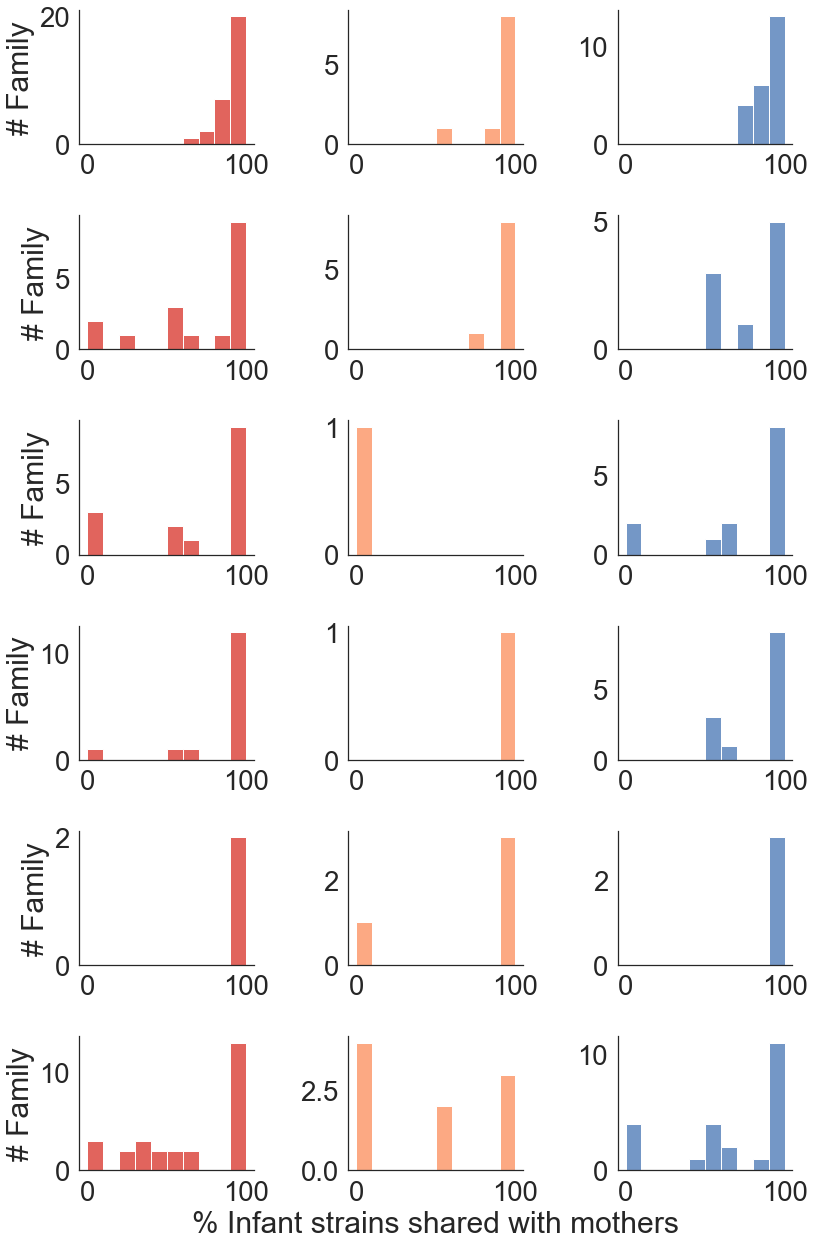

In [106]:
all_overlap_df['% shared ST'] = all_overlap_df['# shared ST']/all_overlap_df['# baby ST']*100
target_lst = np.unique(all_overlap_df['target'])
sns.set(style='white', font_scale=2.5)
color_dct = {"3_yes":"#D73027", "1_yes":"#FC8D59", "4_no":"#4575B4"}
plt.figure(figsize=(12,len(target_lst)*3))
for ti, target in enumerate(target_lst[:]):
    cur_df = all_overlap_df.loc[all_overlap_df['target']==target]
    cur_df = cur_df.loc[cur_df['data type']=='real']
    for gi, grp in enumerate(['3_yes','1_yes','4_no']):
        display_df = cur_df.loc[cur_df['group2']==grp]
        plt.subplot(len(target_lst),3,ti*3+gi+1)
        ax = sns.histplot(data=display_df, x='% shared ST', color=color_dct[grp],
                          bins=np.arange(0,101,10), 
                          stat='count')
        # plt.axvline(np.quantile(shuffled_means_dct[target], 0.9999), linestyle='--', color='black')
        if gi == 1 and ti == len(target_lst)-1:
            plt.xlabel('% Infant strains shared with mothers')
        else:
            plt.xlabel('')
        if gi == 0:
            plt.ylabel('# Family')
        else:
            plt.ylabel('')
        sns.despine(top=True)
plt.tight_layout()
plt.savefig('../figs/AD_strain_babymom_distribution.eps', format='eps')

# Fig 6c

In [136]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if '_St_' not in p and '_N_' not in p and 'T1' not in p and '+' not in p]
straingst_df = pd.DataFrame()
for target in ['Staphylococcus_aureus']:
    print('Proceesing:', target)
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0].split('_genomic')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Select baby-mom pairs
    matrix = straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
    family_dct = {}
    for r in matrix.index:
        fam = r.split('B')[0].split('M')[0]
        babymom = r.split(fam)[1].split('_')[0]
        if fam in family_dct:
            family_dct[fam] = family_dct[fam].union(set([babymom]))
        else:
            family_dct[fam] = set([babymom])
    select_fam = [fam for fam in family_dct if 'B' in family_dct[fam] and 'M' in family_dct[fam]]
    select_runs = [i for i in matrix.index if i.split('B')[0].split('M')[0] in select_fam and 'B+M' not in i]
    select_matrix = matrix.loc[select_runs]
    select_matrix = select_matrix.T.loc[select_matrix.notnull().sum(axis=0) > 0].T
    select_matrix.index = [i.split('_T3')[0] for i in select_matrix.index]
    select_matrix = select_matrix.sort_index()

Proceesing: Staphylococcus_aureus
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch


In [137]:
select_matrix.columns = ['_'.join(col.split('_')[:2]) for col in select_matrix.columns]
select_matrix['group2'] = [patient_info.loc[i.split('_')[0][:-1],'group2'] for i in select_matrix.index]
select_matrix['ID'] = select_matrix.index
display_df = pd.DataFrame()
for group_order in ['3_yes', '1_yes', '2_no', '4_no']:
    cur_mtx = select_matrix.loc[select_matrix['group2']==group_order].sort_values('ID')
    display_df = pd.concat([display_df, cur_mtx], axis=0)
print(display_df.iloc[:,-2:])
display_df = display_df.iloc[:,:-2]

          group2         ID
V1149B_Ac  3_yes  V1149B_Ac
V1149B_Ch  3_yes  V1149B_Ch
V1149M_Ac  3_yes  V1149M_Ac
V981B_Ac   3_yes   V981B_Ac
V981M_Ac   3_yes   V981M_Ac
V1254B_Ch  1_yes  V1254B_Ch
V1254M_Ac  1_yes  V1254M_Ac
V1663B_Ch  1_yes  V1663B_Ch
V1663M_Ac  1_yes  V1663M_Ac
V1943B_Ac  1_yes  V1943B_Ac
V1943B_Ch  1_yes  V1943B_Ch
V1943M_Ac  1_yes  V1943M_Ac
V2063B_Ac  1_yes  V2063B_Ac
V2063B_Ch  1_yes  V2063B_Ch
V2063M_Ac  1_yes  V2063M_Ac
V1014B_Ac   4_no  V1014B_Ac
V1014B_Ch   4_no  V1014B_Ch
V1014M_Ac   4_no  V1014M_Ac
V790B_Ac    4_no   V790B_Ac
V790B_Ch    4_no   V790B_Ch
V790M_Ac    4_no   V790M_Ac
V931B_Ac    4_no   V931B_Ac
V931M_Ac    4_no   V931M_Ac


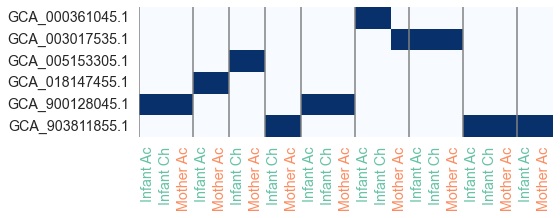

In [139]:
sns.set(style='white', font_scale=1.3)
plt.figure(figsize=(display_df.shape[0]*0.35, display_df.shape[1]*0.55))
ax = sns.heatmap(display_df.notnull().T, cbar=False, cmap='Blues')
plt.ylabel('')

# Add family separation lines
line_pos = []
cur_pos = 0
previous_fam = ''
for i in display_df.index:
    cur_fam = i.split('_')[0][:-1]
    if cur_fam == previous_fam:
        cur_pos += 1
    else:
        previous_fam = cur_fam
        line_pos.append(cur_pos)
        cur_pos += 1
for p in line_pos:
    plt.axvline(p, color='grey')

# Color samples
colors = sns.color_palette('Set2')
for tick_label in ax.axes.get_xticklabels():
    # cur_g = new_patient_info.loc[tick_label.get_text().split('_')[0][:-1], 'eczema_dr_dx']
    # tick_label.set_color(colors[int(cur_g)])
    if 'B' in tick_label.get_text():
        tick_label.set_color(colors[0])
    else:
        tick_label.set_color(colors[1])
newticks = [i.split('_')[0][-1].replace('B', 'Infant ').replace('M', 'Mother ')+i.split('_')[1] for i in display_df.index]
ax.axes.set_xticklabels(newticks);
# plt.legend(labels=['FA', 'AD', 'HC'])
plt.tight_layout()
plt.savefig('../figs/AD_strain_babymom_'+target+'.eps', format='eps')

# Fig S6 T1-T3

In [148]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if 'St' not in p and 'N' not in p and '+' not in p]
all_overlap_df = pd.DataFrame()
shuffled_means_dct = {}
for target in ['Cutibacterium_acnes', 'Dermacoccus_nishinomiyaensis', 'Lactococcus_cremoris', 
               'Lactococcus_lactis', 'Staphylococcus_aureus', 'Staphylococcus_epidermidis']:
    print('Proceesing:', target)
    straingst_df = pd.DataFrame()
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Select T1-T3 pairs
    matrix = straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
    time_matrix = matrix.loc[['M' not in i for i in matrix.index]]
    time_dct = {}
    for r in time_matrix.index:
        if 'T1' in r:
            time = 'T1'
        else:
            time = 'T3'
        sbj = r.split('_')[0]
        if sbj in time_dct:
            time_dct[sbj] = time_dct[sbj].union(set([time]))
        else:
            time_dct[sbj] = set([time])
    select_fam = [sbj for sbj in time_dct if 'T1' in time_dct[sbj] and 'T3' in time_dct[sbj]]
    select_runs = [i for i in matrix.index if i.split('_')[0] in select_fam]
    select_matrix = time_matrix.loc[select_runs]
    select_matrix = select_matrix.T.loc[select_matrix.notnull().sum(axis=0) > 0].T
    select_matrix.index = [i.replace('_T3','')+'_T3' if 'T1' not in i else i for i in select_matrix.index]
    select_matrix = select_matrix.sort_index()

    # Store strains
    ST_dct = {}
    for row in select_matrix.iterrows():
        sbj = row[0].split('_')[0]
        time = row[0].split('_')[2]
        st = set(row[1].index[row[1].notnull()])
        if sbj not in ST_dct:
            ST_dct[sbj] = {time:st}
        else:
            if sbj not in ST_dct[sbj]:
                ST_dct[sbj][time] = st
            else:
                ST_dct[sbj][time] = ST_dct[sbj][time].union(st)
    print(len(ST_dct))

    # Permutation test
    ST_df = pd.DataFrame(ST_dct).T
    overlap_lst = []
    for row in ST_df.iterrows():
        t1_strains = row[1]['T1']
        t3_strains = row[1]['T3']
        overlap_set = row[1][0].intersection(row[1][1])-set(['NF','-'])
        overlap_lst.append(('real',row[0],len(overlap_set), overlap_set, len(t1_strains), len(t3_strains)))
    permut_stats = []
    for i in range(1000):
        np.random.seed(i)
        ST_df.iloc[:,0] = ST_df.iloc[:,0].sample(frac=1).values
        cur_iter = []
        for row in ST_df.iterrows():
            t1_strains = row[1]['T1']
            t3_strains = row[1]['T3']
            overlap_set = row[1][0].intersection(row[1][1])-set(['NF','-'])
            overlap_lst.append(('shuffle', row[0], len(overlap_set), overlap_set, len(t1_strains), len(t3_strains)))
            cur_iter.append(len(overlap_set))
        permut_stats.append(np.mean(cur_iter))
    overlap_df = pd.DataFrame(overlap_lst)
    overlap_df.columns = ['data type', 'ID', '# shared ST', 'shared ST', '# T1 ST', '# T3 ST']
    overlap_df['target'] = target.split('_')[0][0]+'. '+target.split('_')[1]#target_dct[target.split('_')[0]]
    overlap_df['group'] = [patient_info.loc[i[:-1], 'group'] for i in overlap_df['ID']]
    overlap_df['group2'] = [patient_info.loc[i[:-1], 'group2'] for i in overlap_df['ID']]
    all_overlap_df = pd.concat([all_overlap_df, overlap_df], axis=0)
    shuffled_counts = np.array(overlap_df.loc[overlap_df['data type']=='shuffle','# shared ST'])
    shuffled_means = [np.mean(shuffled_counts[i*ST_df.shape[0]:(i+1)*ST_df.shape[0]]) for i in range(1000)]
    # shuffled_means_dct[target_dct[target.split('_')[0]]] = shuffled_means
all_overlap_df = all_overlap_df.reset_index()

Proceesing: Cutibacterium_acnes
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch
67
Proceesing: Dermacoccus_nishinomiyaensis
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V8

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


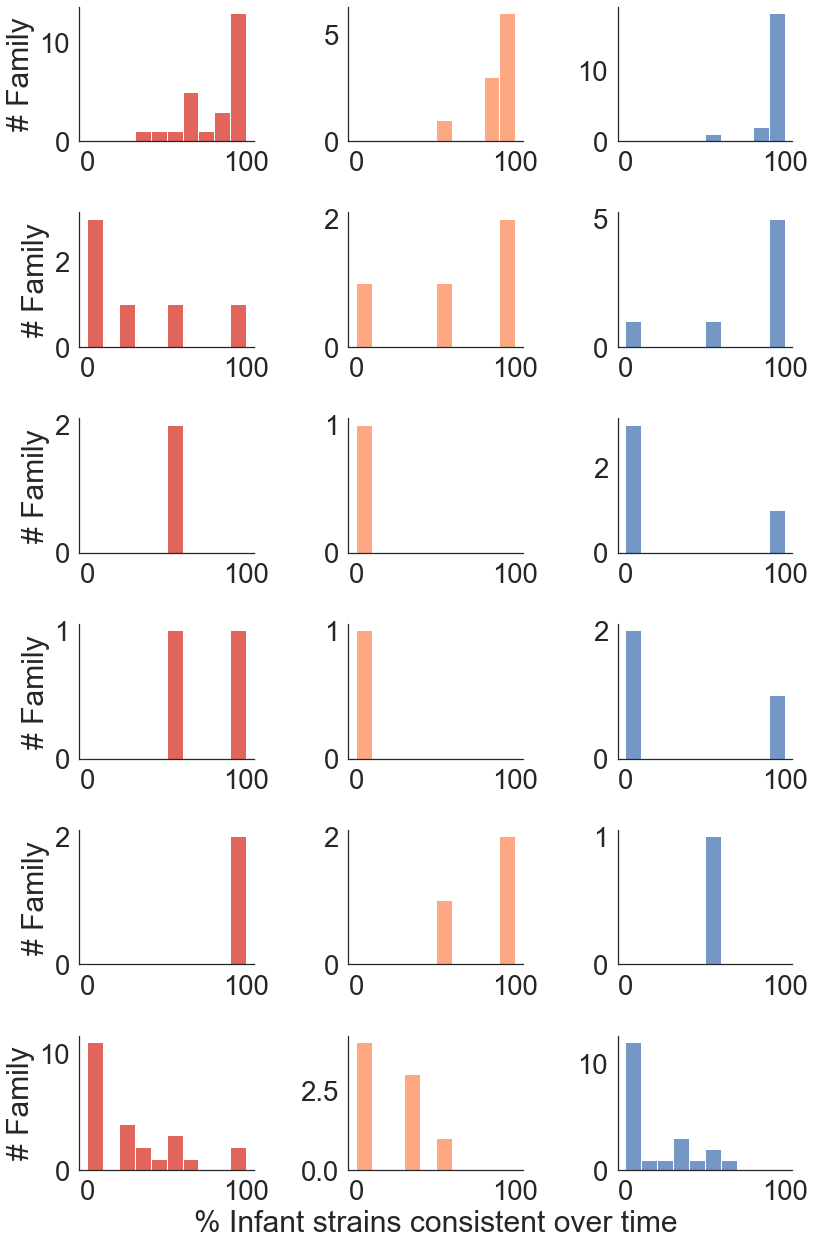

In [152]:
all_overlap_df['% shared ST'] = all_overlap_df['# shared ST']/all_overlap_df['# T1 ST']*100
target_lst = np.unique(all_overlap_df['target'])
sns.set(style='white', font_scale=2.5)
color_dct = {"3_yes":"#D73027", "1_yes":"#FC8D59", "4_no":"#4575B4"}
plt.figure(figsize=(12,len(target_lst)*3))
for ti, target in enumerate(target_lst[:]):
    cur_df = all_overlap_df.loc[all_overlap_df['target']==target]
    cur_df = cur_df.loc[cur_df['data type']=='real']
    for gi, grp in enumerate(['3_yes','1_yes','4_no']):
        display_df = cur_df.loc[cur_df['group2']==grp]
        plt.subplot(len(target_lst),3,ti*3+gi+1)
        ax = sns.histplot(data=display_df, x='% shared ST', color=color_dct[grp],
                          bins=np.arange(0,101,10), 
                          stat='count')
        # plt.axvline(np.quantile(shuffled_means_dct[target], 0.9999), linestyle='--', color='black')
        # if gi == 1:
        #     plt.title(target)
        if gi == 1 and ti == len(target_lst)-1:
            plt.xlabel('% Infant strains consistent over time')
        else:
            plt.xlabel('')
        if gi == 0:
            plt.ylabel('# Family')
        else:
            plt.ylabel('')
        sns.despine(top=True)
plt.tight_layout()
plt.savefig('../figs/AD_strain_t1t3_distribution.eps', format='eps')

In [162]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if 'St' not in p and 'N' not in p and '+' not in p]
all_overlap_df = pd.DataFrame()
shuffled_means_dct = {}
for target in ['Staphylococcus_aureus']:
    print('Proceesing:', target)
    straingst_df = pd.DataFrame()
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Select T1-T3 pairs
    matrix = straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
    time_matrix = matrix.loc[['M' not in i for i in matrix.index]]
    time_dct = {}
    for r in time_matrix.index:
        if 'T1' in r:
            time = 'T1'
        else:
            time = 'T3'
        sbj = r.split('_')[0]
        if sbj in time_dct:
            time_dct[sbj] = time_dct[sbj].union(set([time]))
        else:
            time_dct[sbj] = set([time])
    select_fam = [sbj for sbj in time_dct if 'T1' in time_dct[sbj] and 'T3' in time_dct[sbj]]
    select_runs = [i for i in matrix.index if i.split('_')[0] in select_fam]
    select_matrix = time_matrix.loc[select_runs]
    select_matrix = select_matrix.T.loc[select_matrix.notnull().sum(axis=0) > 0].T
    select_matrix.index = [i.replace('_T3','')+'_T3' if 'T1' not in i else i for i in select_matrix.index]
    select_matrix = select_matrix.sort_index()

    # Store strains
    ST_dct = {}
    for row in select_matrix.iterrows():
        sbj = row[0].split('_')[0]
        time = row[0].split('_')[2]
        st = set(row[1].index[row[1].notnull()])
        if sbj not in ST_dct:
            ST_dct[sbj] = {time:st}
        else:
            if sbj not in ST_dct[sbj]:
                ST_dct[sbj][time] = st
            else:
                ST_dct[sbj][time] = ST_dct[sbj][time].union(st)
    print(len(ST_dct))

Proceesing: Staphylococcus_aureus
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch
8


In [164]:
select_matrix.columns = ['_'.join(col.split('_')[:2]) for col in select_matrix.columns]
select_matrix['group2'] = [patient_info.loc[i.split('_')[0][:-1],'group2'] for i in select_matrix.index]
select_matrix['ID'] = select_matrix.index
display_df = pd.DataFrame()
for group_order in ['3_yes', '1_yes', '2_no', '4_no']:
    cur_mtx = select_matrix.loc[select_matrix['group2']==group_order].sort_values('ID')
    display_df = pd.concat([display_df, cur_mtx], axis=0)
print(display_df.iloc[:,-2:])
display_df = display_df.iloc[:,:-2]

             group2            ID
V1260B_Ac_T1  3_yes  V1260B_Ac_T1
V1260B_Ch_T1  3_yes  V1260B_Ch_T1
V1260B_Ch_T3  3_yes  V1260B_Ch_T3
V1414B_Ac_T1  3_yes  V1414B_Ac_T1
V1414B_Ch_T1  3_yes  V1414B_Ch_T1
V1414B_Ch_T3  3_yes  V1414B_Ch_T3
V1205B_Ac_T1  1_yes  V1205B_Ac_T1
V1205B_Ac_T3  1_yes  V1205B_Ac_T3
V1205B_Ch_T1  1_yes  V1205B_Ch_T1
V1205B_Ch_T3  1_yes  V1205B_Ch_T3
V1223B_Ac_T1  1_yes  V1223B_Ac_T1
V1223B_Ac_T3  1_yes  V1223B_Ac_T3
V1223B_Ch_T1  1_yes  V1223B_Ch_T1
V1223B_Ch_T3  1_yes  V1223B_Ch_T3
V1273B_Ac_T1  1_yes  V1273B_Ac_T1
V1273B_Ac_T3  1_yes  V1273B_Ac_T3
V1273B_Ch_T1  1_yes  V1273B_Ch_T1
V1273B_Ch_T3  1_yes  V1273B_Ch_T3
V1256B_Ac_T1   4_no  V1256B_Ac_T1
V1256B_Ac_T3   4_no  V1256B_Ac_T3
V1256B_Ch_T1   4_no  V1256B_Ch_T1
V1256B_Ch_T3   4_no  V1256B_Ch_T3


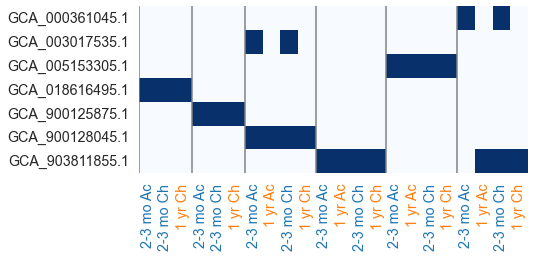

In [171]:
sns.set(style='white', font_scale=1.3)
plt.figure(figsize=(display_df.shape[0]*0.35, display_df.shape[1]*0.55))
ax = sns.heatmap(display_df.notnull().T, cbar=False, cmap='Blues')
plt.ylabel('')

# Add family separation lines
line_pos = []
cur_pos = 0
previous_fam = ''
for i in display_df.index:
    cur_fam = i.split('_')[0][:-1]
    if cur_fam == previous_fam:
        cur_pos += 1
    else:
        previous_fam = cur_fam
        line_pos.append(cur_pos)
        cur_pos += 1
for p in line_pos:
    plt.axvline(p, color='grey')

# Color samples
colors = sns.color_palette('tab10')
for tick_label in ax.axes.get_xticklabels():
    if 'T1' in tick_label.get_text():
        tick_label.set_color(colors[0])
    else:
        tick_label.set_color(colors[1])
newticks = ['2-3 mo '+i.split('_')[1] if 'T1' in i else '1 yr '+i.split('_')[1] for i in display_df.index]
ax.axes.set_xticklabels(newticks);
# plt.legend(labels=['FA', 'AD', 'HC'])
plt.tight_layout()
plt.savefig('../figs/AD_strain_t1t3_'+target+'.eps', format='eps')

# Fig S6 sharing by site

In [174]:
parent_folder = '/home/shenz4/data/Vitality/data/MAG/'
mag_paths = sorted(fnmatch.filter(os.listdir(parent_folder), 'V*'))
mag_paths = [p for p in mag_paths if 'St' not in p and 'N' not in p and '+' not in p]
all_overlap_df = pd.DataFrame()
shuffled_means_dct = {}
for target in ['Cutibacterium_acnes', 'Dermacoccus_nishinomiyaensis', 'Lactococcus_cremoris', 
               'Lactococcus_lactis', 'Staphylococcus_aureus', 'Staphylococcus_epidermidis']:
    print('Proceesing:', target)
    straingst_df = pd.DataFrame()
    
    # Load StrainGE results
    for mag_path in mag_paths:
        try:
            strainge_file = fnmatch.filter(os.listdir(parent_folder+mag_path), '*.'+target+'.k23.tsv')[0]
            strainge_file = parent_folder+mag_path+'/'+strainge_file
            df = pd.read_csv(strainge_file, sep='\t', comment='#', skiprows=2)
            # df['ST'] = [mlst_df.loc[i.split('.fna')[0].split('.fasta')[0], 1] for i in df['strain']] # w/ MLST
            df['ST'] = [i.split('.fna')[0] for i in df['strain']] # w/o MLST
            df['sample'] = mag_path
            df['subject'] = mag_path.split('_')[0]
            straingst_df = pd.concat([straingst_df, df], axis=0)
        except:
            print('Skipping:', mag_path)
    
    # Separate runs on Ac and Ch
    for babySite in ['Ac', 'Ch']:
        cur_straingst_df = straingst_df.loc[['B_'+babySite in i or 'M_Ac' in i for i in straingst_df['sample']]]
        # Select baby-mom pairs
        matrix = cur_straingst_df.pivot_table(index='sample', columns='ST', values='rapct', aggfunc='max')
        family_dct = {}
        for r in matrix.index:
            fam = r.split('B')[0].split('M')[0]
            babymom = r.split(fam)[1].split('_')[0]
            if fam in family_dct:
                family_dct[fam] = family_dct[fam].union(set([babymom]))
            else:
                family_dct[fam] = set([babymom])
        select_fam = [fam for fam in family_dct if 'B' in family_dct[fam] and 'M' in family_dct[fam]]
        select_runs = [i for i in matrix.index if i.split('B')[0].split('M')[0] in select_fam and 'B+M' not in i]
        select_matrix = matrix.loc[select_runs]
        select_matrix = select_matrix.T.loc[select_matrix.notnull().sum(axis=0) > 0].T
        select_matrix = select_matrix.sort_index()

        # Store strains
        ST_dct = {}
        for row in select_matrix.iterrows():
            fam = row[0].split('_')[0][:-1]
            babymom = row[0].split('_')[0][-1]
            st = set(row[1].index[row[1].notnull()])
            if fam not in ST_dct:
                ST_dct[fam] = {babymom:st}
            else:
                if fam not in ST_dct[fam]:
                    ST_dct[fam][babymom] = st
                else:
                    ST_dct[fam][babymom] = ST_dct[fam][babymom].union(st)
        print(babySite, len(ST_dct))

        # Permutation test
        ST_df = pd.DataFrame(ST_dct).T
        overlap_lst = []
        for row in ST_df.iterrows():
            baby_strains = row[1]['B']
            mom_strains = row[1]['M']
            overlap_set = row[1][0].intersection(row[1][1])-set(['NF','-'])
            overlap_lst.append(('real',row[0],len(overlap_set), overlap_set, len(baby_strains), len(mom_strains)))
        permut_stats = []
        for i in range(1000):
            np.random.seed(i)
            ST_df.iloc[:,0] = ST_df.iloc[:,0].sample(frac=1).values
            cur_iter = []
            for row in ST_df.iterrows():
                baby_strains = row[1]['B']
                mom_strains = row[1]['M']
                overlap_set = row[1][0].intersection(row[1][1])-set(['NF','-'])
                overlap_lst.append(('shuffle', row[0], len(overlap_set), overlap_set, len(baby_strains), len(mom_strains)))
                cur_iter.append(len(overlap_set))
            permut_stats.append(np.mean(cur_iter))
        overlap_df = pd.DataFrame(overlap_lst)
        overlap_df.columns = ['data type', 'ID', '# shared ST', 'shared ST', '# baby ST', '# mother ST']
        overlap_df['target'] = target.split('_')[0][0]+'. '+target.split('_')[1]#target_dct[target.split('_')[0]]
        overlap_df['group'] = [patient_info.loc[i, 'group'] for i in overlap_df['ID']]
        overlap_df['group2'] = [patient_info.loc[i, 'group2'] for i in overlap_df['ID']]
        overlap_df['site'] = babySite
        all_overlap_df = pd.concat([all_overlap_df, overlap_df], axis=0)
        shuffled_counts = np.array(overlap_df.loc[overlap_df['data type']=='shuffle','# shared ST'])
        shuffled_means = [np.mean(shuffled_counts[i*ST_df.shape[0]:(i+1)*ST_df.shape[0]]) for i in range(1000)]
        # shuffled_means_dct[target_dct[target.split('_')[0]]] = shuffled_means
all_overlap_df = all_overlap_df.reset_index()

Proceesing: Cutibacterium_acnes
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Skipping: V876B_Ch
Skipping: V891B_Ch
Ac 60
Ch 60
Proceesing: Dermacoccus_nishinomiyaensis
Skipping: V1035B_Ac
Skipping: V1230B_Ac_T3
Skipping: V1260B_Ac
Skipping: V1322B_Ac_T1
Skipping: V1347B_Ac
Skipping: V1376B_Ac
Skipping: V1413B_Ac
Skipping: V1464B_Ch
Skipping: V1465B_Ac
Skipping: V1465B_Ch
Skipping: V1476B_Ac
Skipping: V1476B_Ch
Skipping: V1568B_Ch_T3
Skipping: V1628B_Ch_T3
Skipping: V1682M_Ac_T3
Skipping: V1700B_Ch
Skipping: V1716B_Ac
Skipping: V1881B_Ch_T3
Skipping: V2039B_Ac
Skipping: V2047M_Ac
Skipping: V872M_Ac
Ski

C. acnes Ttest_indResult(statistic=-0.9470266402715091, pvalue=0.34556054314857587)
D. nishinomiyaensis Ttest_indResult(statistic=-0.6848201889509479, pvalue=0.49633335172680393)
L. cremoris Ttest_indResult(statistic=1.499183145414801, pvalue=0.14130580607420784)
L. lactis Ttest_indResult(statistic=0.5295577711390969, pvalue=0.5992068059776914)
S. aureus Ttest_indResult(statistic=0.0, pvalue=1.0)
S. epidermidis Ttest_indResult(statistic=-0.5462110054003702, pvalue=0.5861136596938004)


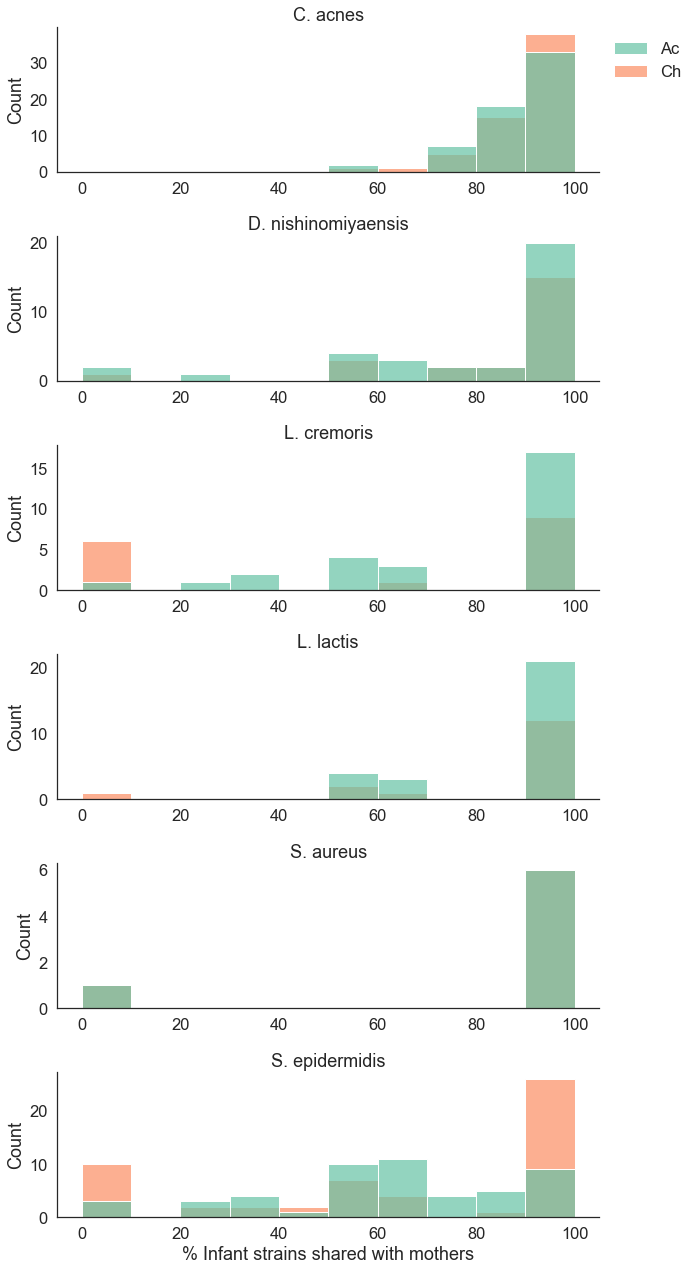

In [181]:
all_overlap_df['% shared ST'] = all_overlap_df['# shared ST']/all_overlap_df['# baby ST']*100
target_lst = np.unique(all_overlap_df['target'])
sns.set(style='white', font_scale=1.5)
sns.set_palette('Set2')
plt.figure(figsize=(10,len(target_lst)*3))
for ti, target in enumerate(target_lst[:]):
    cur_df = all_overlap_df.loc[all_overlap_df['target']==target]
    cur_df = all_overlap_df.loc[all_overlap_df['target']==target]
    plot_df = cur_df.loc[cur_df['data type']=='real']
    plt.subplot(len(target_lst),1,ti+1)
    ax = sns.histplot(data=plot_df, x='% shared ST', hue='site', 
                      # bins=np.arange(0,all_overlap_df['# shared ST'].max()+2), 
                      bins=np.arange(0,101,10), 
                      stat='count', alpha=0.7)
    print(target, stats.ttest_ind(plot_df.loc[plot_df['site']=='Ac', '% shared ST'], plot_df.loc[plot_df['site']=='Ch', '% shared ST']))
    # plt.axvline(np.quantile(shuffled_means_dct[target], 0.9999), linestyle='--', color='black')
    plt.title(target)
    # plt.xlim(0,all_overlap_df['# shared ST'].max()+1)
    # plt.ylim(0,15)
    if ti == 0:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), frameon=False, title='')
    else:
        plt.legend([],[], frameon=False)
    if ti == len(target_lst)-1:
        plt.xlabel('% Infant strains shared with mothers')
    else:
        plt.xlabel('')
    sns.despine(top=True)
plt.tight_layout()
# plt.savefig('../figs/AD_strain_babymom_site_distribution.png', format='png')